In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()
weight = {}
weight_sum = {}


start_t = time.time()
data_year = 'full'
pdgId = 13
analyzer_version = "/v1/vBDT4/"
ntupler_version ='V1p17'
ctau = [ 100, 1000, 10000, 100000]
years = ['Summer16', 'Fall17', 'Fall18']
mass = [15, 40, 55]



# data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/vBDT/v2/normalized/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/vBDT/v2/normalized/'


data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/v5/vBDT4/normalized/'
fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+ntupler_version+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'


for y in years:
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_'+y+'/'+analyzer_version+'/normalized/'
    tune = 'TuneCP5'
    if y == 'Summer16': tune = 'TuneCUETP8M1'
    for m in mass:
        for ct in ctau:
            key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
            fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'
            print(fpath[key])


NEvents = {}

NEvents_genweight = {}
for k,v in fpath.items():
#     print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    weight[k] = tree[k]["weight"].array()
    weight_sum[k] = np.sum(weight[k])
    print("NEvents",k,NEvents[k], len(weight[k]))

print(time.time()-start_t)

/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Summer16//v1/vBDT4//normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Summer16//v1/vBDT4//normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Summer16//v1/vBDT4//normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Summer16//v1/vBDT4//normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Summer16//v1/vBDT4//normalized/ggH_HToSSTobbbb_MH-125_MS-40_ctau-100_TuneCU

# Helper Functions

In [3]:


# Imports
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

variables = [
            ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', '$\Delta x_{cluster}$', 600, 0, 120],
             ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', '$\Delta y_{cluster}$', 600, 0, 120],
#              ['cscRechitClusterZSpread', 'cscRechitClusterZSpread', '$\Delta z_{cluster}$', 600, 0, 120],
             ['cscRechitClusterNStation', 'cscRechitClusterNStation', 'N_{station}$', 5, 0, 5],

            ['cscRechitClusterEtaPhiSpread', 'cscCRechitlusterEtaPhiSpread', '$\Delta \eta\times\phi_{cluster}$', 100, -4, -4],
            ['cscRechitClusterX', 'cscRechitClusterX', '$x_{cluster}$', 1100, -1100, 1100],
            ['cscRechitClusterY', 'cscRechitClusterY', '$y_{cluster}$', 1100, -1100, 1100],
            ['cscRechitClusterZ', 'cscRechitClusterZ', '$z_{cluster}$', 1100, -1100, 1100],
            ]



variables = [
            
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterEtaSpread', 'cscRechitClusterEtaSpread', '$\eta$ spread', 30, 0, 0.3],
            ['cscRechitClusterPhiSpread', 'cscRechitClusterPhiSpread', '$\phi$ spread', 30, 0, 0.3],
            ['cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaPhiSpread', '$\eta-\phi$ spread', 30, 0, 0.15],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0, 2.5],
            ['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100],
            ]

variables = [
#              ['cscRechitClusterZSpread', 'cscRechitClusterZSpread', '$\Delta z_{cluster}$', 30, 0, 200],
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', 'X spread [cm]', 30, 0, 100],
            ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', 'Y spread [cm]', 30, 0, 100],
            ['cscRechitClusterXYSpread', 'cscRechitClusterXYSpread', 'XY spread [cm]', 30, 0, 100],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0, 2.5],
            ['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100],
#             ['cscRechitClusterTimeTotal', 'cscRechitClusterTimeTotal', 'cluster time [ns]', 50, -15, 25],

            ]




variables = [
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
            ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
            ['cscRechitClusterXYSpread', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4],

            ]
variables_mc = [
            ['cscRechitClusterNStation5', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterXSpread_corr', 'cscRechitClusterXSpread', 'X spread [cm]', 50, 0, 150],
            ['cscRechitClusterYSpread_corr', 'cscRechitClusterYSpread', 'Y spread [cm]', 50, 0, 150],
            ['cscRechitClusterXYSpread_corr', 'cscRechitClusterXYSpread', 'XY spread [cm]', 50, 0, 150],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4],
            ]


variables = [
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation5', 'cscRechitClusterAvgStation5', 'cluster station', 30, 1, 4],
            ]
variables = [
            ['cscRechitClusterNStation10', 'cscRechitClusterNStation10', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  25, 0.5, 2.5],
            ['cscRechitClusterAvgStation10', 'cscRechitClusterAvgStation10', 'average station', 30, 1, 4],
            ['cscRechitClusterSize', 'cscRechitClusterSize', 'N_{rechits}', 30, 0, 4000],


            ]

## load root files to dataframes

In [4]:
lumi_year = {
    'Summer16': 35.92,
    'Fall17':41.53,
    'Fall18':59.74,
}

df_signal = {
    15: dict(),
    40:dict(),
    55:dict(),
}
weight_signal = {
    15: dict(),
    40:dict(),
    55:dict(),
}
    
for ct in ctau:
    for m in mass:

        df_signal_list  = []
        weight_signal[m][ct] = []
        nevents = 0
        for y in years:
            key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
#             weight[key] = tree[key]["weight"].array()/weight_sum[key]*10*lumi_year[y]
            df_signal_temp = uproot.open(fpath[key])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)
            df_signal_list.append(df_signal_temp)
#             weight_signal[m][ct] = weight_signal[m][ct] + [lumi_year[y]/len(df_signal_temp)]*len(df_signal_temp)
            weight_signal[m][ct] = weight_signal[m][ct] + [lumi_year[y]]*len(df_signal_temp) #v5

            nevents+=len(df_signal_temp)
        print(ct, m, nevents)
#             print(key, len(weight_signal), len(df_signal_temp))
        df_signal[m][ct] = pd.concat(df_signal_list)

df_bkg = uproot.open(fpath['data'])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)



100 15 6957
100 40 70
100 55 1
1000 15 345664
1000 40 128907
1000 55 33266
10000 15 128251
10000 40 273814
10000 55 191863
100000 15 14840
100000 40 42228
100000 55 33075


In [6]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

### plot input variables

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


15 100 6957
15 1000 345664
15 10000 128251
15 100000 14840
40 100 70
40 1000 128907
40 10000 273814
40 100000 42228
55 100 1
55 1000 33266
55 10000 191863
55 100000 33075


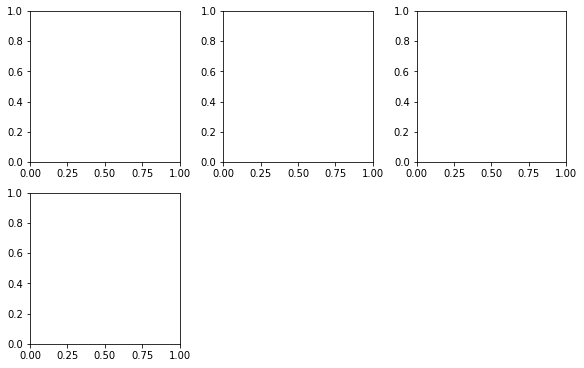

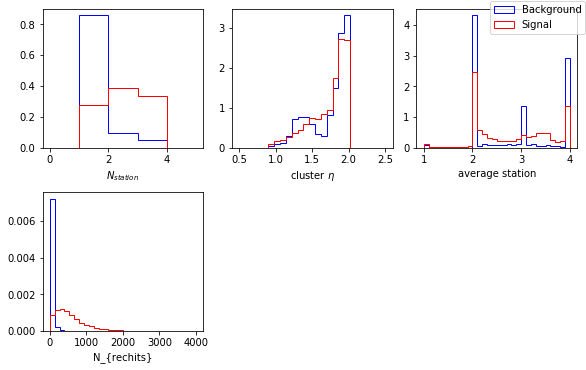

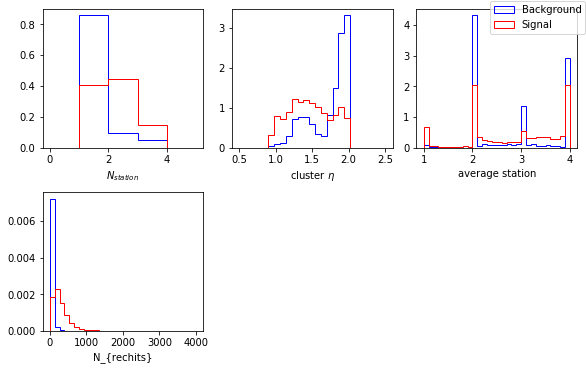

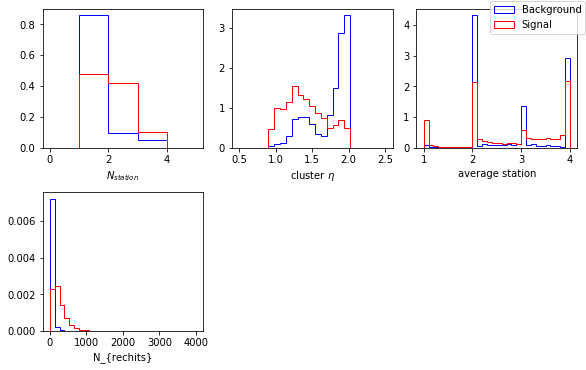

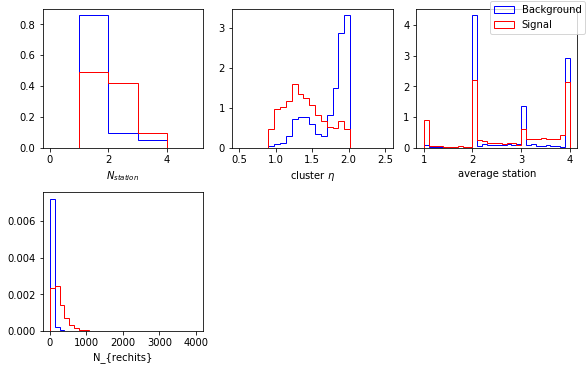

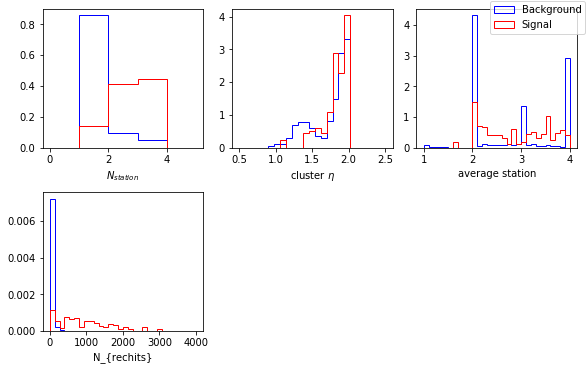

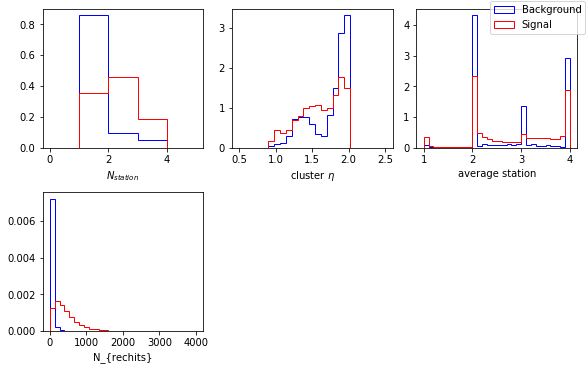

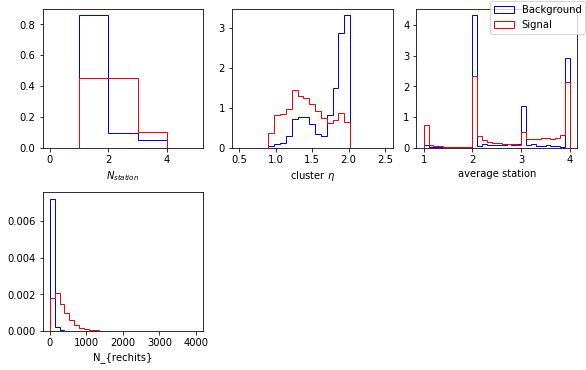

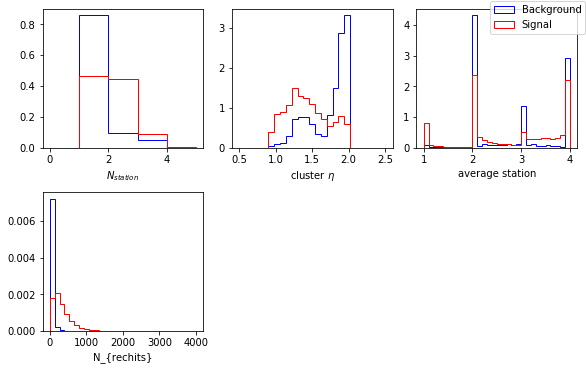

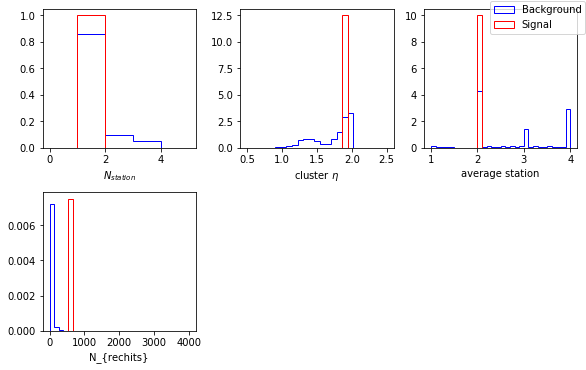

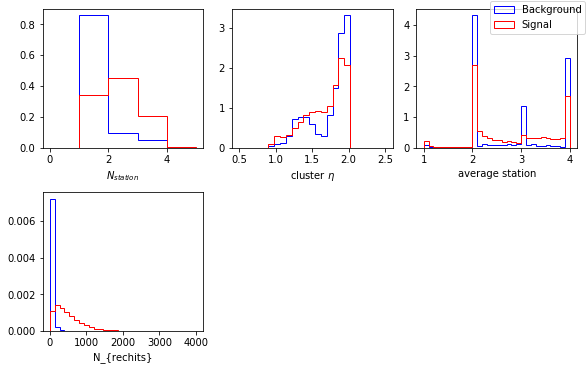

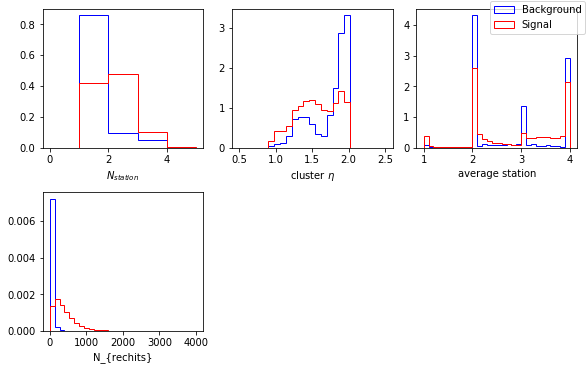

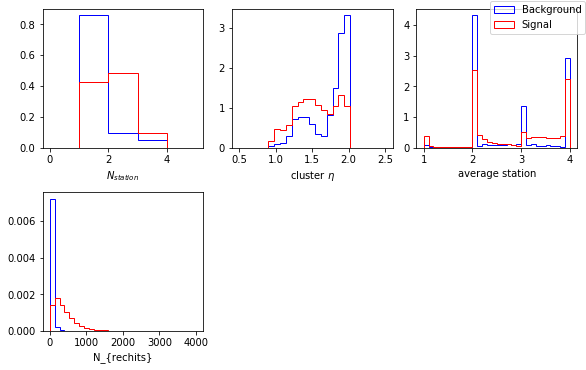

In [7]:


columns = 3

fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
# fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(6,8), constrained_layout=True)
trim_axs(axs, len(variables))


for m in mass:
    for ct in ctau:
        r = 0
        c = 0
        fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
        trim_axs(axs, len(variables))
        for i, var in enumerate(variables):
        #     if not (i == 2 or i == 5): continue
            bkg = axs[r,c].hist(np.abs(df_bkg.values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
            sig = axs[r,c].hist(np.abs(df_signal[m][ct].values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, weights = weight_signal[m][ct], histtype = 'step', label = 'Signal', color = 'r')
        #     axs[r,c].legend()
            axs[r,c].set_xlabel(variables[i][2])
            if c == columns-1:
        #         if r == 0:axs[r,c].legend(loc = 'upper right')
                c = 0
                r+=1

            else:c+=1
        #     if i == len(variables)-1:
        fig1.legend([bkg, sig],     # The line objects
                   labels=['Background', 'Signal'],   # The labels for each line
                   loc="upper right",   # Position of legend
                   borderaxespad=0.1,    # Small spacing around legend box
                   )
#         plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
        print(m, ct, len(df_signal[m][ct]))

# plot the time

15 100000 14462
40 100000 49237
55 100000 76740
['Background', 'ggH, $m_{x}$ = 15 GeV', 'ggH, $m_{x}$ = 40 GeV', 'ggH, $m_{x}$ = 55 GeV']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


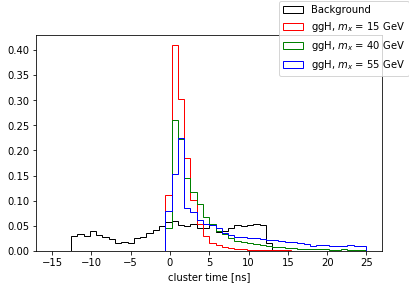

In [63]:
ct = 10000

colors = ['r', 'g', 'b', 'c', 'y']

f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)

sig = {}
w = {}
hist = {}
labels = ['Background']
i = len(variables)-1


bkg = ax.hist(time_bkg, variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'k')
for r, m in enumerate(mass):
    for j, ct in enumerate(ctau):
        if j == 0: 
            sig[m] = np.abs(df_signal[m][ct].values[:,i])
            w[m] = weight_signal[m][ct]
#                 w[m] = noweight_llp[m][ct]
        else: 
            sig[m] = np.hstack((sig[m],np.abs(df_signal[m][ct].values[:,i])))
            w[m] =  np.hstack((w[m], weight_signal[m][ct]))


    hist[m] = ax.hist(sig[m], variables[i][3], (variables[i][4], variables[i][5]), density = True, weights = w[m], \
                            histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[r])
    labels.append('ggH, $m_{x}$ = ' +str(m)+' GeV')
    ax.set_xlabel(variables[i][2])


    

#     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
    print(m, ct, len(df_signal[m][ct]))
print(labels)
f.legend([bkg,sig.items()],     # The line objects
           labels=labels,   # The labels for each line
           loc="best",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
#            bbox_to_anchor=(0.0, 0.0, 0.5, 0.5),
)    
# fig1.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)








# uncertainty wrt to eta distribution

In [5]:
#cluster efficiency in terms of eta
import root_numpy
version = 'v24'

path = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/\
cluster_eff_year2017_norm50_V1p17'+version+'_tag_probe/'
print(path)
# suffix = "_Nrechits130"
suffix = ""
f = rt.TFile(path+'efficiency_Zmass120_800_muon50_norm50.root')
f.Get("data_ZMass")
data_eff_temp = f.Get("data_muonEta"+suffix)
mc_eff_temp = f.Get("dy_120_800_muonEta"+suffix)
data_eff = data_eff_temp.GetCopyPassedHisto()
mc_eff = mc_eff_temp.GetCopyPassedHisto()
for i in range(data_eff.GetXaxis().GetNbins()+1):
    data_eff.SetBinContent(i+1,data_eff_temp.GetEfficiency(i+1))
    mc_eff.SetBinContent(i+1,mc_eff_temp.GetEfficiency(i+1))
    data_eff.SetBinError(i+1,max(data_eff_temp.GetEfficiencyErrorLow(i+1), data_eff_temp.GetEfficiencyErrorUp(i+1)))
    mc_eff.SetBinError(i+1,max(mc_eff_temp.GetEfficiencyErrorLow(i+1), mc_eff_temp.GetEfficiencyErrorUp(i+1)))

# sf_eff = data_eff.GetCopyPassedHisto()
# sf_eff.Divide(data_eff.GetCopyTotalHisto())
# denom = mc_eff.GetCopyPassedHisto()
# denom.Divide(mc_eff.GetCopyTotalHisto())
# sf_eff.Divide(denom)
sf_eff = data_eff
sf_eff.Divide(mc_eff)
unc_list = sf_eff
print(root_numpy.hist2array(unc_list))
for i in range(sf_eff.GetXaxis().GetNbins()+1):
    print(sf_eff.GetBinContent(i+1),sf_eff.GetBinError(i+1))

/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year2017_norm50_V1p17v24_tag_probe/
[0.         0.22123163 0.45261582 0.72500307 0.73982393 0.91834606
 1.03993694 0.60554708 0.97928858 1.22728736 0.95731806 1.06810721]
0.0 0.6749093846570994
0.22123162727966153 0.09540761474318074
0.4526158227446556 0.14518330264549578
0.7250030709540713 0.23713738874284654
0.7398239309944572 0.1585154957317823
0.9183460638164258 0.21057807276191065
1.0399369360840782 0.2372549239526886
0.6055470780292029 0.13364279875162077
0.9792885800352195 0.24418107772670966
1.2272873610849422 0.25792917795801623
0.9573180574446808 0.15548318636991618
1.0681072058393317 0.1545953852530081
0.5935898007555696 0.26083221154745073


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


In [68]:
#cluster id efficiency in terms of Nstation

nstation_x = np.array([1,2,3,4])
hist_binwidth = 1
unc_list = nstation_x * 0.0
# data/mc
unc_list[0] = 0.662422304025104/0.6502910709495691
unc_list[1] = 0.7992248554546032/0.8252725498791024
unc_list[2] = 0.7584605175846052/0.7934158423663757
unc_list[3] = 0.872436108368981/0.9014365345737896
unc_list = np.abs(unc_list-1)


In [7]:

# def signal_weight(unc_list, eta_distribution):
#     index = (eta_distribution/hist_binwidth).astype(int)
# #     print(eta_distribution[:10], index[:10])
# #     assert(np.max(eta_distribution)<=2.0)
#     return unc_list[index]

def signal_weight(sf_eff, eta_distribution):
    unct = []
    for ele in eta_distribution:
        unct.append(sf_eff.GetBinContent(sf_eff.GetXaxis().FindFixBin(ele)))
    return np.array(unct)
def signal_weight_unc(sf_eff, eta_distribution):
    unct = []
    for ele in eta_distribution:
        # relative uncertainty
#         unct.append(sf_eff.GetBinError(sf_eff.GetXaxis().FindFixBin(ele))/sf_eff.GetBinContent(sf_eff.GetXaxis().FindFixBin(ele)))
        unct.append(sf_eff.GetBinError(sf_eff.GetXaxis().FindFixBin(ele)))
    return np.array(unct)

def eta2(eta_distribution):
    output = []
    for i, ele in enumerate(eta_distribution):
#         if np.abs(ele) < 1.8:
        if np.abs(ele)>1.8 and np.abs(ele)<2.0:
            output.append(1.0)
        else:
            output.append(0.0)
    return np.array(output)
def cut_based(x):
    cond2 = np.logical_and(x[:,2]==2, x[:,1] < 1.7)
    cond3 = np.logical_and(x[:,2]==3, x[:,1] < 1.8)
    cond4 = np.logical_and(x[:,2]==4, x[:,1] < 1.9)
    cond1 = np.logical_and(x[:,0]==1, np.logical_or(np.logical_or(x[:,2]==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(x[:, 0] > 1, x[:,1] < 1.9)
    cond = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    return cond



In [16]:
import pickle
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
bdt_cut = 0.50882477
model = pickle.load(open( bdt_name+'.pickle', "rb" ))




100 15 -0.053869135033212334
100 40 0.001381172456847768
1000 15 -0.15758620170103865
1000 40 -0.10140866323919595
1000 55 -0.07745100451549969
10000 15 -0.19073556599912567
10000 40 -0.17319839170489326
10000 55 -0.11794071766575298
100000 15 -0.19448549994146347
100000 40 -0.18235484853045314
100000 55 -0.12482379654336284
signal uncertainty -0.15055645267768214 -0.15055645267768192 0.06340538151879668


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year2017_norm50_V1p17v24_tag_probe/


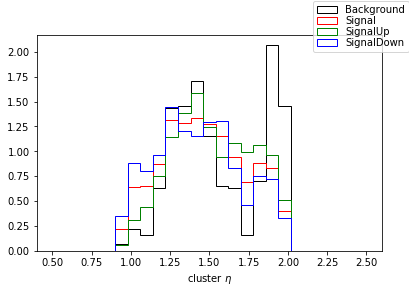

In [8]:
method1 = False
singleMuon = True

f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)

i = 1
# change the function -1 when Nstation, no -1 when eta
# y_pred = model.predict_proba(df_bkg.values)[:, 1]
y_pred = cut_based(df_bkg.values)
if suffix == "_Nrechits130": 
    print("_Nrechits130")
    y_pred = np.logical_and(y_pred, df_bkg.values[:,3] >= 130)
bkg = ax.hist(np.abs(df_bkg.values[:,i][y_pred]), variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'k')


for j, ct in enumerate(ctau):
    for k, m in enumerate(mass):
#         y_pred = model.predict_proba(df_signal[m][ct].values)[:, 1]
        y_pred = cut_based(df_signal[m][ct].values)
        if suffix == "_Nrechits130": y_pred = np.logical_and(y_pred, df_signal[m][ct].values[:,3] >= 130)
        if j+k==0: 
            sig = np.abs(df_signal[m][ct].values[:,i])[y_pred]
            w = np.array(weight_signal[m][ct])[y_pred]
        else: 
            sig = np.hstack((sig,np.abs(df_signal[m][ct].values[:,i][y_pred])))
            w =  np.hstack((w, np.array(weight_signal[m][ct])[y_pred]))
        if np.count_nonzero(y_pred)>0:
            print(ct, m, np.sum(np.array(weight_signal[m][ct])[y_pred]*(signal_weight(unc_list, np.abs(df_signal[m][ct].values[:,i])[y_pred])))/np.sum(np.array(weight_signal[m][ct])[y_pred])-1)
sig_weight = signal_weight(unc_list, sig)
# sig_weight_unc = signal_weight_unc(unc_list, sig)
# unique, counts = np.unique(sig_weight_unc, return_counts=True)
# sig_weight_unc = np.sum((unique*counts)**2)**0.5

sig_weight_unc = 0
sig_hist = create_TH1D(sig, 'hm1', axis_title = ['',''], binning=[unc_list.GetXaxis().GetNbins(), unc_list.GetXaxis().GetXmin(), unc_list.GetXaxis().GetXmax()], weights = w)
for j in range(sig_hist.GetXaxis().GetNbins()+1):
    sig_weight_unc += (sig_hist.GetBinContent(j+1)*sf_eff.GetBinError(j+1))**2
sig_weight_unc = sig_weight_unc**0.5


sig_hist = ax.hist(sig, variables[i][3], (variables[i][4], variables[i][5]), density = True, weights =w, histtype = 'step', color = 'r')
sig_up = ax.hist(sig, variables[i][3], (variables[i][4], variables[i][5]), density = True, weights =w*(sig_weight), histtype = 'step', color = 'g')
sig_down = ax.hist(sig, variables[i][3], (variables[i][4], variables[i][5]), density = True, weights =w*(2-sig_weight), histtype = 'step', color = 'b')

total_unc = np.sum(w*(sig_weight))/np.sum(w)-1
print("signal uncertainty", np.sum(w*(sig_weight))/np.sum(w)-1,1-np.sum(w*(2-sig_weight))/np.sum(w), sig_weight_unc/np.sum(w))
# print("signal uncertainty up and down", np.sum(w*(sig_weightUp))/np.sum(w)-1,\
#       np.sum(w*(sig_weightDown))/np.sum(w)-1)
# print("signal uncertainty up and down", abs(np.sum(w*(sig_weightUp))/np.sum(w)-1-total_unc),\
#       abs(np.sum(w*(sig_weightDown))/np.sum(w)-1-total_unc))


# print(np.sum(w*(1+np.abs(1-sig_weight)))/np.sum(w)-1,1-np.sum(w*(1-np.abs(1-sig_weight)))/np.sum(w))


ax.set_xlabel(variables[i][2])
# plt.yscale('log')

       
f.legend([sig_up],
    [bkg, sig_hist, sig_up, sig_down],     # The line objects
           labels=['Background', 'Signal', 'SignalUp', 'SignalDown'],   # The labels for each line
#          labels = ['sig up'],
           loc="best",   # Position of legendb
           borderaxespad=0.1,    # Small spacing around legend box
#            bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),
           labelspacing = 0.1,
)    


plt.savefig(path+"/signal_uncertainty"+suffix+".png", dpi=300)
print(path)

In [34]:
sig_weight_unc = signal_weight_unc(unc_list, sig)
unique, counts = np.unique(sig_weight_unc, return_counts=True)
print(dict(zip(unique, counts)))

{0.09540761474318074: 21989,
 0.13364279875162077: 101426,
 0.14518330264549578: 59986,
 0.1545953852530081: 45784,
 0.15548318636991618: 85170,
 0.1585154957317823: 108117,
 0.21057807276191065: 109260,
 0.23713738874284654: 61199,
 0.2372549239526886: 113361,
 0.24418107772670966: 82711,
 0.25792917795801623: 60829}

In [49]:
print(np.sum((unique*counts)**2)**0.5/np.sum(w))
print(np.sum((unique*counts)**2)**0.5,np.sum(w))
print(np.sum(counts), len(w))

0.0013345208408576449
53856.8375207121 40356685.239999995
849832 849832


# plot one variable for all masses

55 100 21
55 100 21
55 100 21
55 100 21
55 100 21
55 100 21
55 100 21


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


55 1000 40473
55 1000 40473
55 1000 40473
55 1000 40473
55 1000 40473
55 1000 40473
55 1000 40473
55 10000 319916
55 10000 319916
55 10000 319916
55 10000 319916
55 10000 319916
55 10000 319916
55 10000 319916
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020


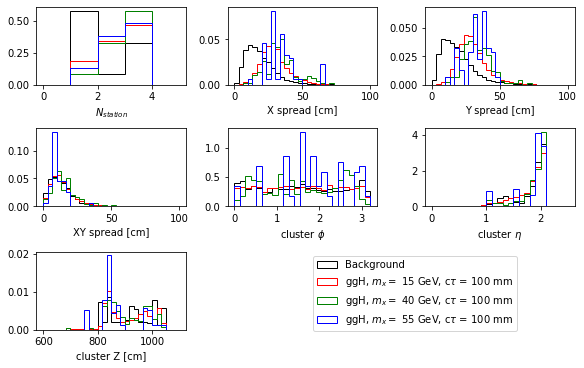

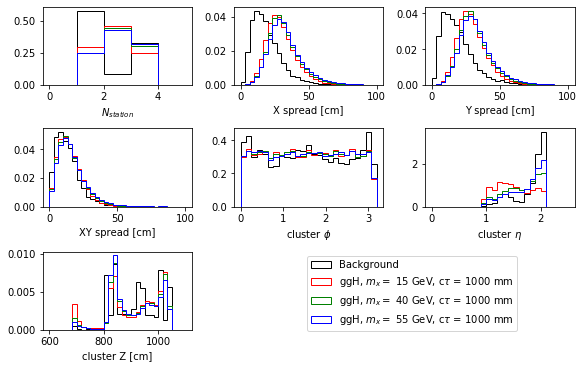

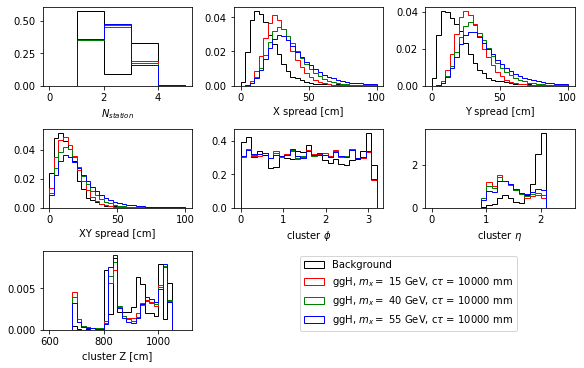

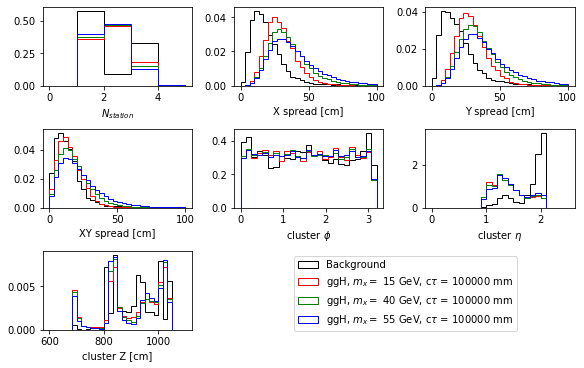

In [30]:
for ct in [100, 1000, 10000, 100000]:

    colors = ['r', 'g', 'b', 'c', 'y']

    columns = 3
    fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
    trim_axs(axs, len(variables))
    r = 0
    c = 0
    labels = ['Background']
    for i, var in enumerate(variables):
    #     fig1 = plt.figure()
        sig = {}
        bkg = axs[r,c].hist(np.abs(df_bkg.values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'k')
    #     plt.xlabel(variables[i][2],horizontalalignment='right', x=1.0, fontsize=15)
        for j, m in enumerate(mass):
            sig[m] = axs[r,c].hist(np.abs(df_signal[m][ct].values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, weights = weight_signal[m][ct], histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[j])
            if i == 0: labels.append('ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
            axs[r,c].set_xlabel(variables[i][2])


        if c == columns-1:
            c = 0
            r+=1
        else:c+=1

    #     plt.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
    #     plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
    #     plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)


    #     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
        print(m, ct, len(df_signal[m][ct]))

    fig1.legend([bkg, sig[15], sig[40], sig[55]],     # The line objects
               labels=labels,   # The labels for each line
               loc="lower right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),

    )    

    # os.makedirs('../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread')
    plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread/compareMass_ctau-"+str(ct)+'mm.png', dpi=300)



# plot one variable for all ctau

15 100000 14527
15 100000 14527
15 100000 14527
15 100000 14527
15 100000 14527
15 100000 14527
15 100000 14527


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


40 100000 49397
40 100000 49397
40 100000 49397
40 100000 49397
40 100000 49397
40 100000 49397
40 100000 49397
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020
55 100000 77020


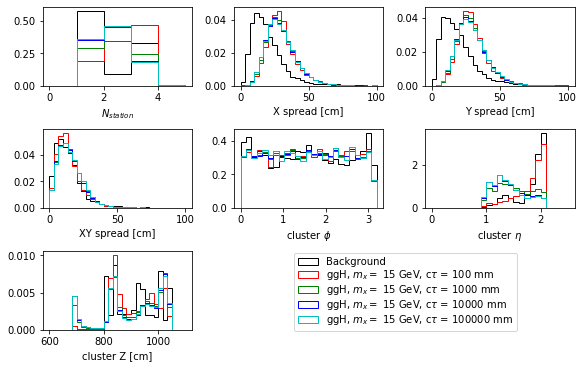

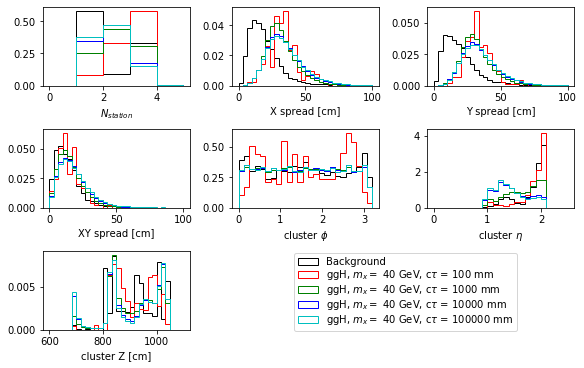

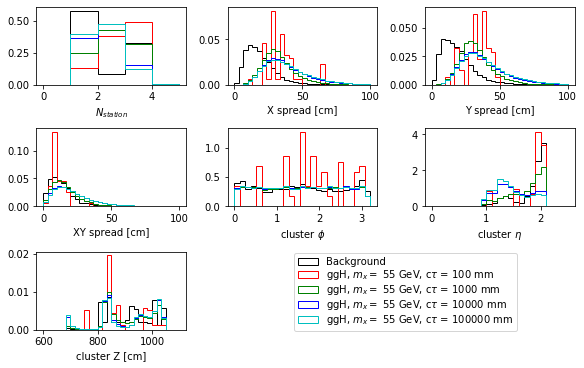

In [29]:
# m = 55
for m in [15,40,55]:
    colors = ['r', 'g', 'b', 'c', 'darkorange']
    columns = 3

    fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
    trim_axs(axs, len(variables))
    r = 0
    c = 0
    labels = ['Background']
    plots = []

    for i, var in enumerate(variables):
        sig = {}
        bkg = axs[r,c].hist(np.abs(df_bkg.values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'k')
        if i == 0:plots.append(bkg)
        for j, ct in enumerate(ctau):
            sig[ct] = axs[r,c].hist(np.abs(df_signal[m][ct].values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, weights = weight_signal[m][ct], histtype = 'step', color = colors[j])
            axs[r,c].set_xlabel(variables[i][2])
            if i == 0: 
                labels.append('ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
                plots.append(sig[ct])
        if c == columns-1:
            c = 0
            r+=1
        else:c+=1
    #     plt.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
    #     plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
    #     plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)


    #     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
        print(m, ct, len(df_signal[m][ct]))

    fig1.legend(plots,     # The line objects
               labels=labels,   # The labels for each line
               loc="lower right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),
               labelspacing = 0.1,
    )    

    plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread/comparect_MS-"+str(m)+'.png', dpi=300)




# plot all the signal points in one plot

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 0.33, ' $m_{x} =$ 55 GeV')

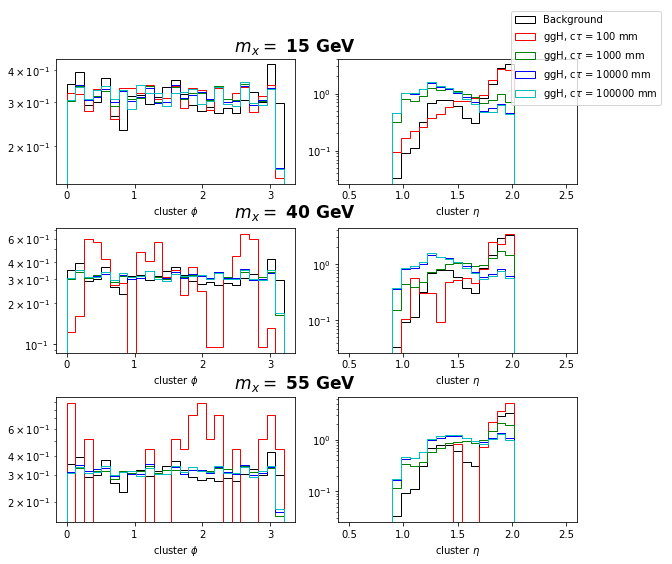

In [16]:

colors = ['r', 'g', 'b', 'c', 'y']

columns = 2
fig1, axs = plt.subplots(3, columns, figsize=(8,7), constrained_layout=True)
# trim_axs(axs, len(llp_variables))
r = 0
c = 0
labels = ['Background']
for c, var_i in enumerate([1,2]):
    for r, m in enumerate(mass):
        sig = {}
        bkg = axs[r,c].hist(np.abs(df_bkg.values[:,var_i]), variables[var_i][3], (variables[var_i][4], variables[var_i][5]), density = True, \
                                     histtype = 'step',  color = 'k', label = 'Background')
        
        for j, ct in enumerate(ctau):
            sig[ct] = axs[r,c].hist(np.abs(df_signal[m][ct].values[:,var_i]), variables[var_i][3], (variables[var_i][4], variables[var_i][5]), density = True, \
                                    weights = weight_signal[m][ct], histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[j])
            
            if i == 0 and r == 0: labels.append('ggH, c$\\tau$ = ' +str(int(ct))+' mm')
            axs[r,c].set_xlabel(variables[var_i][2])
            axs[r,c].set_yscale('log')
            if c == 0 and r == 0: labels.append('ggH, c$\\tau$ = ' +str(int(ct))+' mm')



#     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
        
fig1.legend([bkg, sig.items()],     # The line objects
           labels=labels,   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.55, 0.6, 0.6, 0.5),
)    


# fig1.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
x_pos = 0.5
fig1.text(x_pos, 1, ' $m_{x} =$ '+str(15)+' GeV', ha='center', va='bottom',  weight='bold', fontsize=17)
fig1.text(x_pos, 0.67, ' $m_{x} =$ '+str(40)+' GeV', ha='center', va='bottom',  weight='bold', fontsize=17)
fig1.text(x_pos, 0.33, ' $m_{x} =$ '+str(55)+' GeV', ha='center', va='bottom', weight='bold', fontsize=17)


# plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_v2/compareMass_ctau-"+str(ct)+'mm.png')





# plot the sum of the signals

55 100000 37162
55 100000 37162
55 100000 37162
55 100000 37162


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


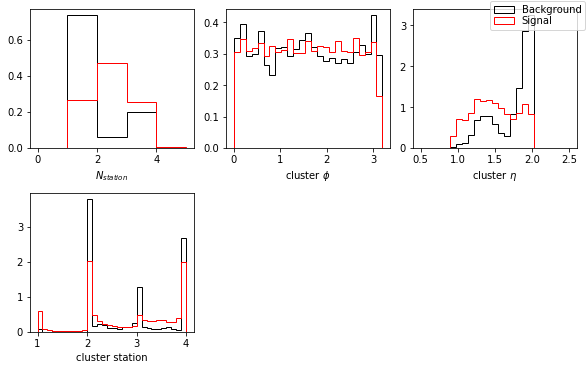

In [17]:
columns = 3
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,5), constrained_layout=True)
trim_axs(axs, len(variables))
r = 0
c = 0
labels = ['Background']
plots = []
sig_hist = {}
for i, var in enumerate(variables):
    bkg = axs[r,c].hist(np.abs(df_bkg.values[:,i]), variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'k')
    if i == 0:plots.append(bkg)
    for j, ct in enumerate(ctau):
        
        for k, m in enumerate(mass):
            if j+k==0: 
                sig = np.abs(df_signal[m][ct].values[:,i])
                w = weight_signal[m][ct]
            else: 
                sig = np.hstack((sig,np.abs(df_signal[m][ct].values[:,i])))
                w =  np.hstack((w, weight_signal[m][ct]))
        
    sig_hist[i] = axs[r,c].hist(sig, variables[i][3], (variables[i][4], variables[i][5]), density = True, weights =w, histtype = 'step', color = 'r')
    axs[r,c].set_xlabel(variables[i][2])
#     labels.append('ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
    plots.append(sig)
    if c == columns-1:
        c = 0
        r+=1
    else:c+=1
#     plt.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
#     plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
#     plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)


#     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
    print(m, ct, len(df_signal[m][ct]))
        
fig1.legend([bkg, sig_hist[i]],     # The line objects
           labels=['Background', 'Signal'],   # The labels for each line
           loc="best",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
#            bbox_to_anchor=(0.4, 0.1, 0.5, 0.5),
           labelspacing = 0.1,
)    

# plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread/allSig_bkg.png", dpi=300)





# plot 2d correlation plot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


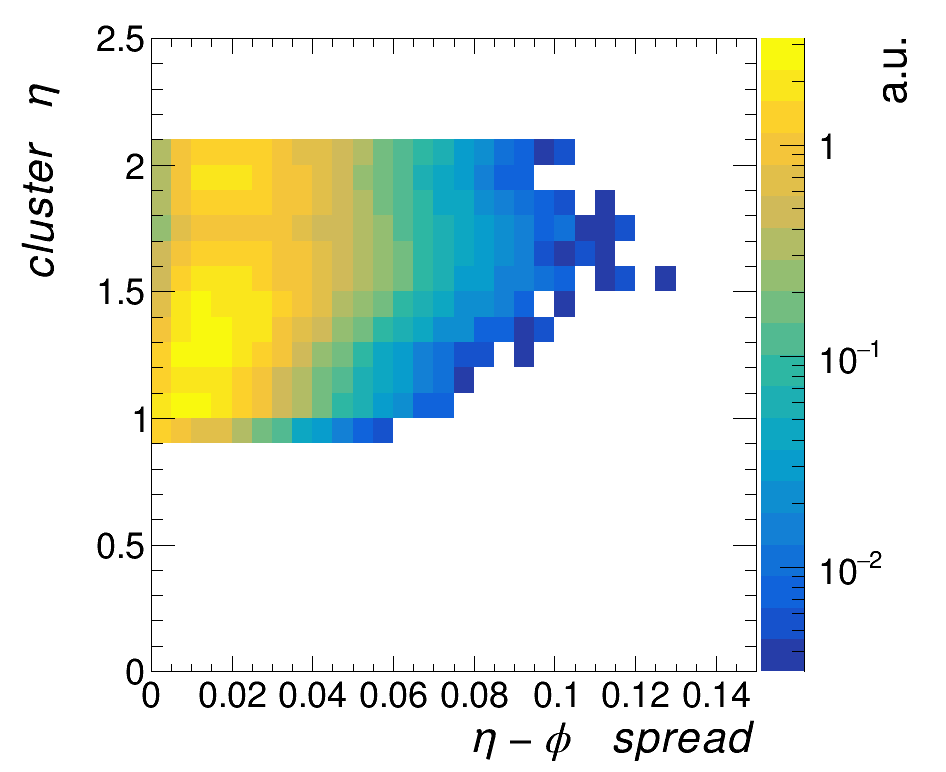

In [22]:
i = 5
j = 7
sig_i = []
sig_j = []
weight = []
c = rt.TCanvas('c','c', 950, 800)
rt.gStyle.SetOptFit(1011)
for m in mass:
    for ct in ctau:
        if not (m==15 and ct==1000):continue
        sig_i += list(np.abs(df_signal[m][ct].values[:,i]))
        sig_j += list(np.abs(df_signal[m][ct].values[:,j]))
        weight += list(weight_signal[m][ct])


bkg = np.abs(df_bkg.values[:,i])

h = create_TH2D(np.column_stack((sig_i, sig_j)), 
                      axis_title=[variables[i][2], variables[j][2], 'a.u.'], \
                binning = [variables[i][3], variables[i][4], variables[i][5], variables[j][3], variables[j][4], variables[j][5]],weights = weight)

   
h.Draw('colz')
# plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_v2/comparect_MS-"+str(m)+'.png')
c.SetLogz()
c.SetRightMargin(0.2)
c.Draw()
# c.Draw("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_v2/2d_"+variables[i][0]+'_'+variables[j][0]+'.png')



# load bdt

In [ ]:
import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v3.pickle', "rb" ))

# plot ROC curve for different models

0.7820899813137847
0.8142857142857143
0.9079597528235512
0.8473162822810243
0.8005471051524079
0.927680875782645
0.9128386422900217
0.8579819975711837
0.9282345013477089
0.9155062991380127
0.8676946334089192
../../plots/MuonSystem_Analysis/bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3/ROC_curve_allSig.png


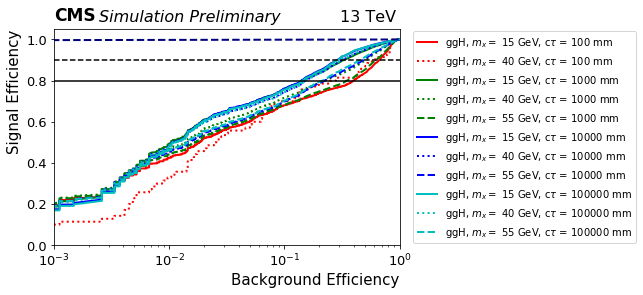

In [8]:
import pickle
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3'
model = pickle.load(open( bdt_name+'.pickle', "rb" ))
BDT_cut = 0.30789274

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)

lw = 2
colors = ['r', 'g', 'b', 'c']
linestyle = ['solid', 'dotted', 'dashed']
# for i, ct in enumerate([10000]):
for i, ct in enumerate(ctau):


    for j, m in enumerate(mass):
        if ct == 100 and m == 55:continue
        x = np.concatenate([df_bkg.values,df_signal[m][ct].values])
        x = np.abs(x) ## change the last two variables to positive
        y = np.concatenate([np.zeros(len(df_bkg)),np.ones(len(df_signal[m][ct]))])
        y_pred = model.predict_proba(x)[:, 1]

        fpr, tpr, thr = roc_curve(y, y_pred)
        plt.plot(fpr, tpr, color=colors[i],linestyle = linestyle[j], lw=2, label='ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
#         print('{0} \t {1} \t {2}'.format(ct, m, tpr[np.argmin(np.abs(thr-BDT_cut))]), fpr[np.argmin(np.abs(thr-BDT_cut))])
#         print('{0} \t {1}\t {2}'.format(ct, m, tpr[np.argmin(np.abs(thr-BDT_cut))]))
        print('{0}'.format(tpr[np.argmin(np.abs(thr-BDT_cut))]))




plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
# plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
# plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
# #plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
# plt.title('Receiver operating characteristic example')
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.25, 0.5, 0.5))
plt.text(0.0, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.13, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(0.99, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

plt.savefig("../../plots/MuonSystem_Analysis/"+bdt_name+"/ROC_curve_allSig.png", dpi=300,bbox_inches='tight')
print("../../plots/MuonSystem_Analysis/"+bdt_name+"/ROC_curve_allSig.png")
plt.show()


# LLP Z/R

In [32]:


llp_variables = [
            
            ['cscRechitCluster_match_gLLP_decay_z', 'cscRechitCluster_match_gLLP_decay_z', 'LLP decay z [cm]', 30, 600, 1100],
            ['cscRechitCluster_match_gLLP_decay_r', 'cscRechitCluster_match_gLLP_decay_r', 'LLP decay R [cm]',30, 100, 800],
           
            ]



llp_decay = {
    15: dict(),
    40:dict(),
    55:dict(),
}
weight_llp = {
    15: dict(),
    40:dict(),
    55:dict(),
}
noweight_llp = {
    15: dict(),
    40:dict(),
    55:dict(),
}
for m in mass:
    for ct in ctau:
        llp_decay_list  = []
        weight_llp[m][ct] = []
        noweight_llp[m][ct] = []
        for y in years:
            key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
            llp_decay_temp = uproot.open(fpath[key])['MuonSystem'].pandas.df([row[0] for row in llp_variables], flatten=True)
            llp_decay_list.append(llp_decay_temp)
            weight_llp[m][ct] = weight_llp[m][ct] + [lumi_year[y]/len(llp_decay_temp)]*len(llp_decay_temp)
            noweight_llp[m][ct] = noweight_llp[m][ct] + [lumi_year[y]]*len(llp_decay_temp)


#             print(key, len(weight_signal), len(df_signal_temp))
        llp_decay[m][ct] = pd.concat(llp_decay_list)
        weight_llp[m][ct] = np.array(weight_llp[m][ct])
        noweight_llp[m][ct] = np.array(noweight_llp[m][ct])


        print(len(llp_decay[m][ct]), len(weight_llp[m][ct]))


8538 8538
332047 332047
122454 122454
14527 14527
139 139
133453 133453
290304 290304
49397 49397
21 21
40473 40473
319916 319916
77020 77020


# plot time for all signals

55 10000 320173
55 10000 320173


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


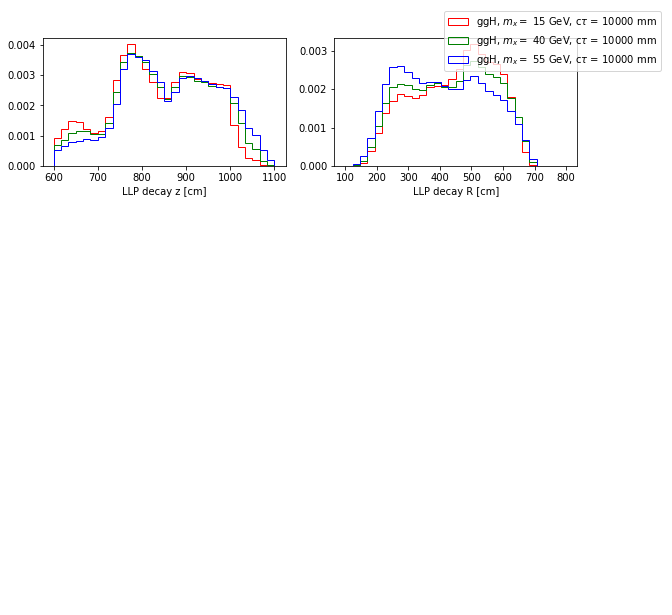

In [328]:
ct = 10000

colors = ['r', 'g', 'b', 'c', 'y']

columns = 2
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(8,8), constrained_layout=True)
trim_axs(axs, len(llp_variables))
r = 0
c = 0
labels = []
for i, var in enumerate(llp_variables):
#     fig1 = plt.figure()
    sig = {}
    for j, m in enumerate(mass):
        sig[m] = axs[r,c].hist(np.abs(llp_decay[m][ct].values[:,i]), llp_variables[i][3], (llp_variables[i][4], llp_variables[i][5]), density = True, weights = weight_llp[m][ct], histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[j])
        if i == 0: labels.append('ggH, $m_{x} =$ '+str(m)+' GeV, c$\\tau$ = ' +str(int(ct))+' mm')
        axs[r,c].set_xlabel(llp_variables[i][2])


    if c == columns-1:
        c = 0
        r+=1
    else:c+=1

#     plt.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
#     plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
#     plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)


#     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
    print(m, ct, len(df_signal[m][ct]))
        
fig1.legend([bkg, sig[15], sig[40], sig[55]],     # The line objects
           labels=labels,   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.65, 0.55, 0.5, 0.5),
)    
# plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_v2/compareMass_ctau-"+str(ct)+'mm.png')



55 100000 77020
55 100000 77020


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


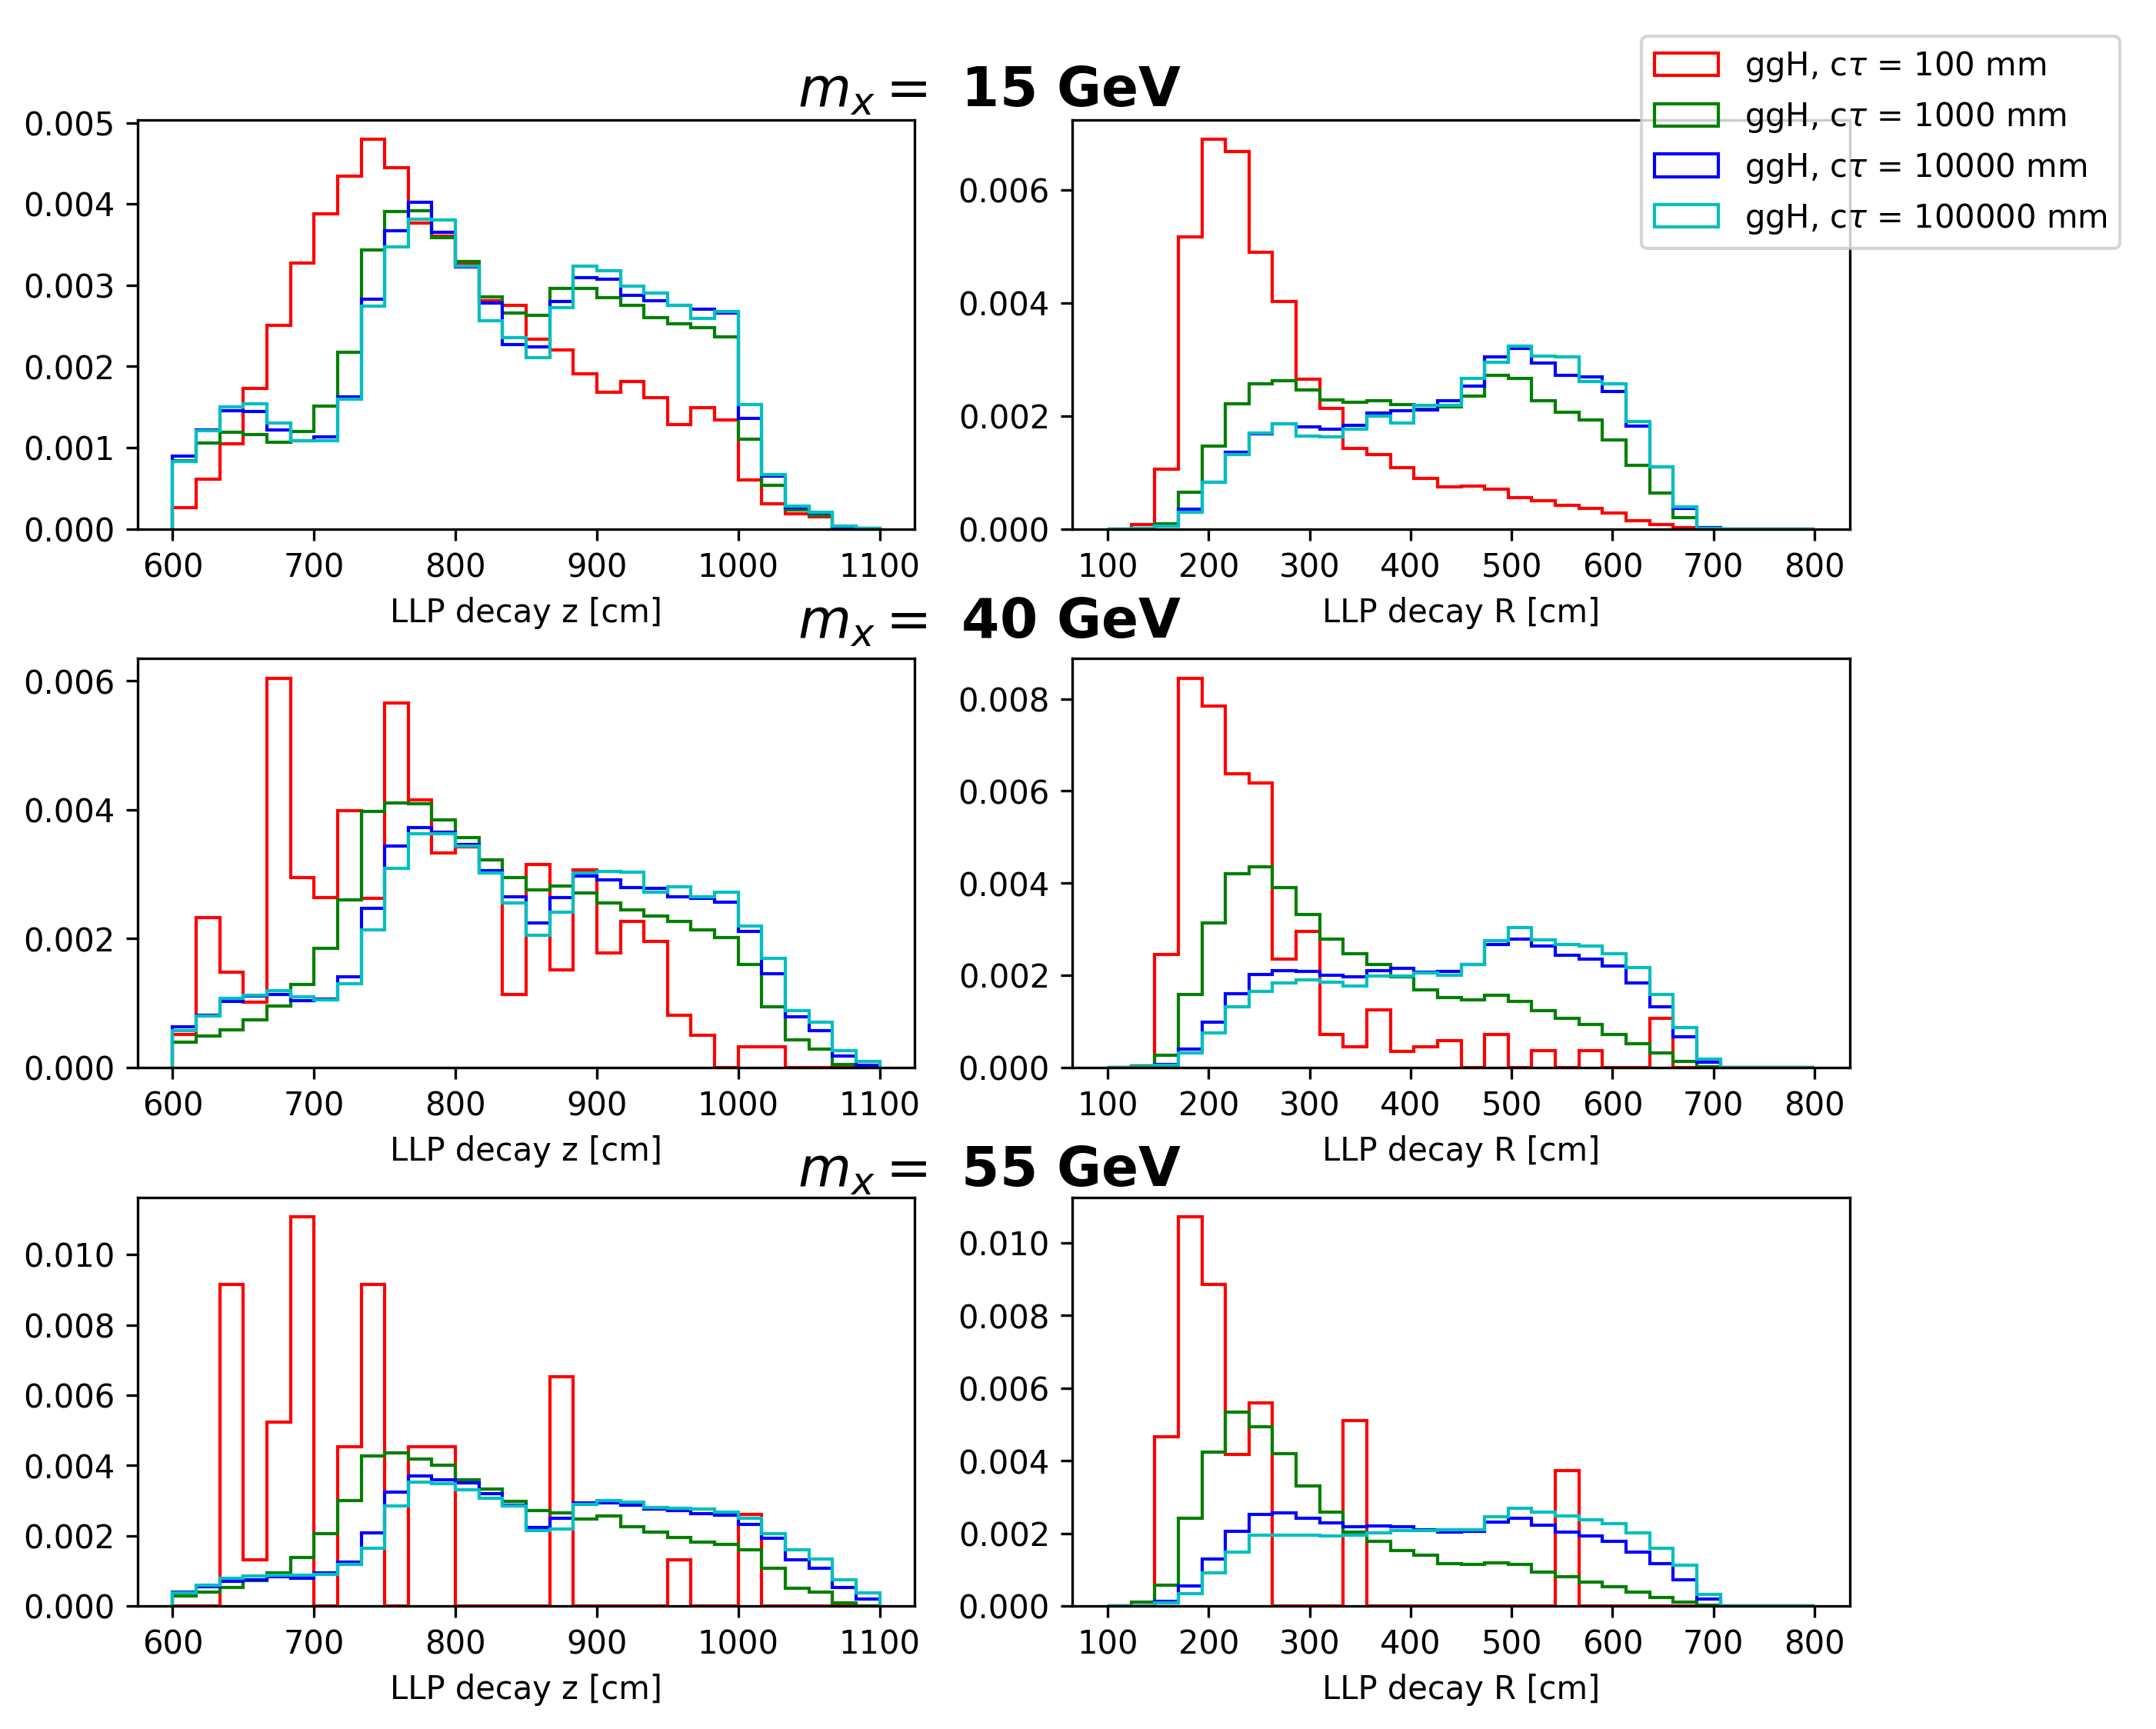

In [53]:
figure.dpi       : 300
savefig.dpi      : 300
colors = ['r', 'g', 'b', 'c', 'y']

columns = 2
fig1, axs = plt.subplots(3, columns, figsize=(8,7), constrained_layout=True, dpi=300)
figure.dpi       : 300
savefig.dpi      : 300
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# trim_axs(axs, len(llp_variables))
r = 0
c = 0
labels = []
for i, var in enumerate(llp_variables):
#     fig1 = plt.figure()
    for r, m in enumerate(mass):
        
        sig = {}
        for j, ct in enumerate(ctau):
            c = i
            sig[ct] = axs[r,c].hist(np.abs(llp_decay[m][ct].values[:,i]), llp_variables[i][3], (llp_variables[i][4], llp_variables[i][5]), density = True, weights = weight_llp[m][ct], histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[j])


            if i == 0 and r == 0: labels.append('ggH, c$\\tau$ = ' +str(int(ct))+' mm')
            axs[r,c].set_xlabel(llp_variables[i][2])

    print(m, ct, len(df_signal[m][ct]))
        
fig1.legend(sig.items(),     # The line objects
           labels=labels,   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.65, 0.55, 0.5, 0.5),
)    
# fig1.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
x_pos = 3.5
fig1.text(x_pos, 3, ' $m_{x} =$ '+str(55)+' GeV', ha='center', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
fig1.text(x_pos, 6.3, ' $m_{x} =$ '+str(40)+' GeV', ha='center', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
fig1.text(x_pos, 9.5, ' $m_{x} =$ '+str(15)+' GeV', ha='center', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)




plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread/separateSig_llp_decay.png", dpi=gcf().dpi,bbox_inches='tight')

plt.show()

<Figure size 1800x1200 with 0 Axes>

55 100000 77020
55 100000 77020


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


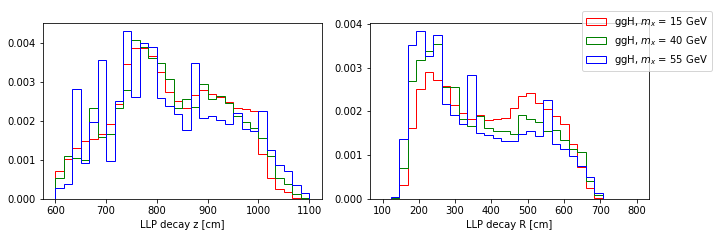

In [36]:

colors = ['r', 'g', 'b', 'c', 'y']

columns = 2
fig1, axs = plt.subplots(1, columns, figsize=(9,3), constrained_layout=True)
# trim_axs(axs, len(llp_variables))

labels = []
for i, var in enumerate(llp_variables):
#     fig1 = plt.figure()
    sig = {}
    w = {}
    hist = {}
    for r, m in enumerate(mass):
        for j, ct in enumerate(ctau):
            if j == 0: 
                sig[m] = np.abs(llp_decay[m][ct].values[:,i])
                w[m] = weight_llp[m][ct]
#                 w[m] = noweight_llp[m][ct]
            else: 
                sig[m] = np.hstack((sig[m],np.abs(llp_decay[m][ct].values[:,i])))
                w[m] =  np.hstack((w[m], weight_llp[m][ct]))
#                 w[m] =  np.hstack((w[m], noweight_llp[m][ct]))


        hist[m] = axs[i].hist(sig[m], llp_variables[i][3], (llp_variables[i][4], llp_variables[i][5]), density = True, weights = w[m], \
                                histtype = 'step', label = 'ggH, m_x = '+str(m)+' GeV', color = colors[r])
        if i == 0: labels.append('ggH, $m_{x}$ = ' +str(m)+' GeV')
        axs[i].set_xlabel(llp_variables[i][2])


    

#     plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg/"+variables[i][0]+"_MS-"+str(m)+"_ctau-"+str(ct)+'mm.png')
    print(m, ct, len(df_signal[m][ct]))
        
fig1.legend(sig.items(),     # The line objects
           labels=labels,   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.60, 0.55, 0.5, 0.5),
)    
# fig1.text(-0.1, 1.02, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.03, 1.02, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(0.87, 1.02, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

plt.savefig("../../plots/MuonSystem_Analysis/bdtTrainingVar_signal_vs_bkg_XYspread/allSig_llp_decay.png", dpi=300,bbox_inches='tight')


